In [10]:
#이미지 주소 넣기
inputImagePath="C:/Users/eun51/Downloads/testImage.jpg"

{0: 1.0}
[[ 65.86700075 118.46420395 146.37275591]]


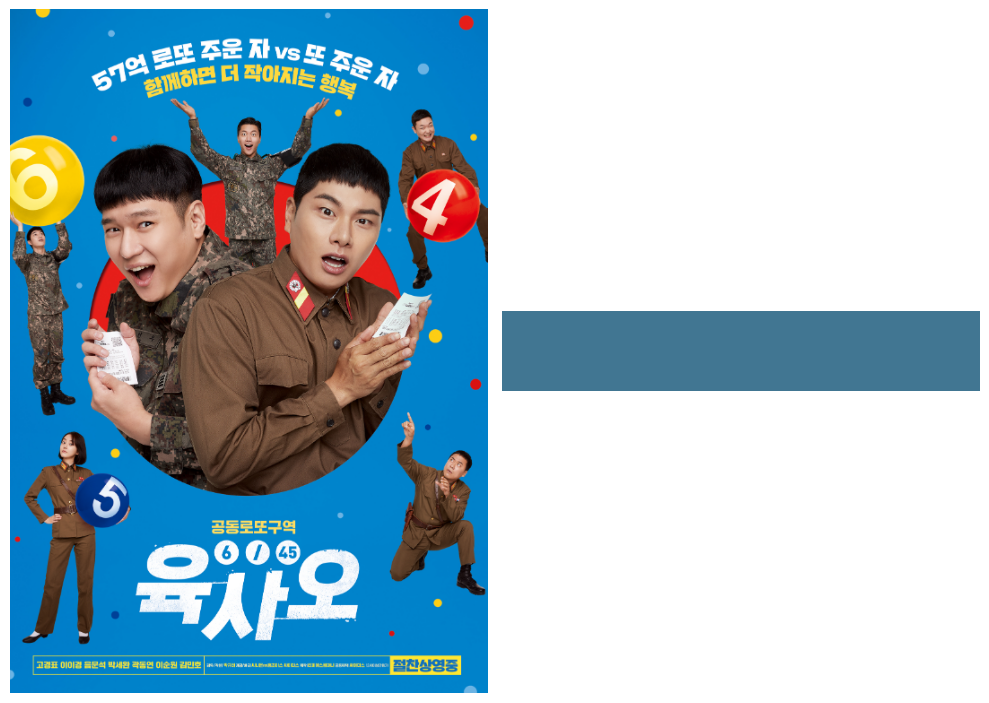

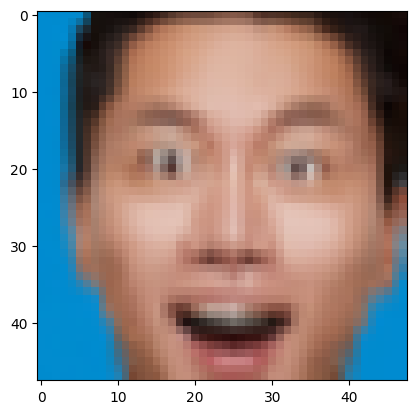

1/1 [==============================] - 1s 984ms/step
[array([[3.1840149e-03, 1.7555976e-04, 4.7989883e-02, 1.2103387e-02,
        5.4433849e-04, 9.3539327e-01, 6.0950028e-04]], dtype=float32), array([[7.1554044e-03, 3.7153214e-04, 1.1450893e-01, 7.2821970e-03,
        6.2826653e-03, 8.5065204e-01, 1.3747249e-02]], dtype=float32), array([[1.6013654e-03, 3.8860315e-05, 6.2047139e-02, 4.7821645e-03,
        5.2083138e-04, 9.2994988e-01, 1.0598268e-03]], dtype=float32)]
[3.9802617e-03 1.9531739e-04 7.4848644e-02 8.0559161e-03 2.4492785e-03
 9.0533179e-01 5.1388587e-03]
5


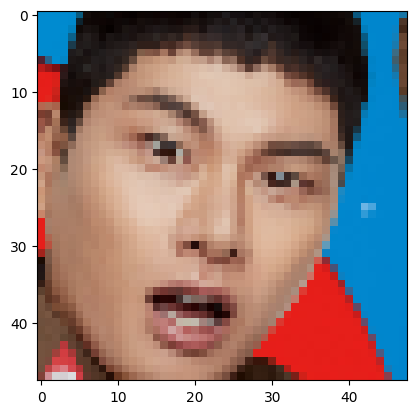

1/1 [==============================] - 0s 93ms/step
[array([[0.06170091, 0.00123812, 0.14067075, 0.02199265, 0.11653899,
        0.07906585, 0.57879275]], dtype=float32), array([[0.09322353, 0.00276335, 0.1700038 , 0.02079056, 0.1541759 ,
        0.1834428 , 0.37560013]], dtype=float32), array([[0.08992306, 0.00357033, 0.18342339, 0.02821732, 0.08292393,
        0.47740862, 0.1345333 ]], dtype=float32)]
[0.08161584 0.00252393 0.16469932 0.02366684 0.11787961 0.24663909
 0.3629754 ]
6
1/1 [==============================] - 0s 122ms/step


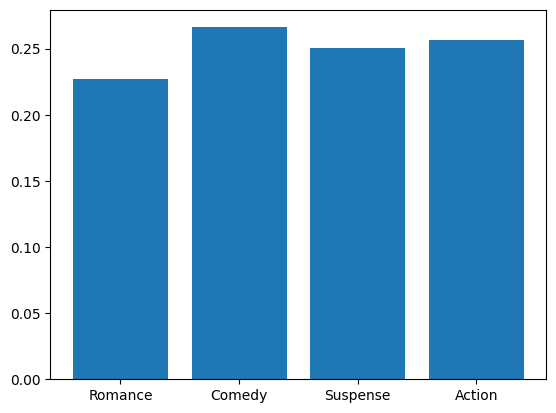

예측된 장르는 Comedy입니다.


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from keras import models 
from keras.models import load_model
from collections import Counter

#주요 색상 예측 함수
def palette_perc(k_cluster):
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    
    n_pixels = len(k_cluster.labels_)
    counter = Counter(k_cluster.labels_) # count how many pixels per cluster
    perc = {}
    for i in counter:
        perc[i] = np.round(counter[i]/n_pixels, 2)
    perc = dict(sorted(perc.items()))
    
    #for logging purposes
    print(perc)
    print(k_cluster.cluster_centers_)
    
    step = 0
    
    for idx, centers in enumerate(k_cluster.cluster_centers_): 
        palette[:, step:int(step + perc[idx]*width+1), :] = centers
        step += int(perc[idx]*width+1)
        
    return palette

#RGB to HUE&Tone
def ColorSystem(RGB):
    oneBitImg=np.uint8([[RGB]])
    hsv=cv2.cvtColor(oneBitImg,cv2.COLOR_RGB2HSV)
    
    # h: 색상, s:채도, v:명도
    h=hsv[0][0][0]
    
    '''    
    R 빨강 (Red) YR 주황 (Yellow Red) Y 노랑 (Yellow) GY 연두 (GreenYellow)
    G 녹색 (Green) BG 청록 (Blue Green) B 파랑 (Blue)
    PB 남색 (Purple Blue) P 보라 (Purple) RP 자주 (Red Purple)
    '''
    #180/10
    if (18*0<=h)and(18*1>=h):
        colorNum=[1,0,0,0,0,0,0,0,0,0]
    elif (18*1<h)and(18*2>=h):
        colorNum=[0,1,0,0,0,0,0,0,0,0]
    elif (18*2<h)and(18*3>=h):
        colorNum=[0,0,1,0,0,0,0,0,0,0]
    elif (18*3<h)and(18*4>=h):
        colorNum=[0,0,0,1,0,0,0,0,0,0]   
    elif (18*4<h)and(18*5>=h):
        colorNum=[0,0,0,0,1,0,0,0,0,0]     
    elif (18*5<h)and(18*6>=h):
        colorNum=[0,0,0,0,0,1,0,0,0,0]     
    elif (18*6<h)and(18*7>=h):
        colorNum=[0,0,0,0,0,0,1,0,0,0]       
    elif (18*7<h)and(18*8>=h):
        colorNum=[0,0,0,0,0,0,0,1,0,0]     
    elif (18*8<h)and(18*9>=h):
        colorNum=[0,0,0,0,0,0,0,0,1,0]
    elif (18*9<h)and(18*10>=h):
        colorNum=[0,0,0,0,0,0,0,0,0,1]

    return colorNum

def load_detection_model(model_path):
    detection_model = cv2.CascadeClassifier(model_path)
    return detection_model

def detect_faces(detection_model, gray_image_array):
    return detection_model.detectMultiScale(gray_image_array, 1.3, 5)

def draw_bounding_box(face_coordinates, image_array, color):
    x, y, w, h = face_coordinates
    cv2.rectangle(image_array, (x, y), (x + w, y + h), color, 2)

def apply_offsets(face_coordinates, offsets):
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x + width + x_off, y - y_off, y + height + y_off)

def draw_text(coordinates, image_array, text, color, x_offset=0, y_offset=0,
                                                font_scale=0.5, thickness=2):
    x, y = coordinates[:2]
    cv2.putText(image_array, text, (x + x_offset, y + y_offset),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale, color, thickness, cv2.LINE_AA)
    
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

#이미지 가져오기
img = cv2.imread(inputImagePath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#색상 인식
clt = KMeans(n_clusters=1)
clt.fit(img.reshape(-1, 3))

f, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax[1].imshow(palette_perc(clt))
ax[0].axis('off') #hide the axis
ax[1].axis('off')
f.tight_layout()
plt.show()

RGB=[]
RGB.append(int(clt.cluster_centers_[0][0]))
RGB.append(int(clt.cluster_centers_[0][1]))
RGB.append(int(clt.cluster_centers_[0][2]))

ColorNum=ColorSystem(RGB)

#표정 인식
# 표정 인식 모델 가져오기
detection_model_path = 'C:/Users/eun51/Downloads/haar-cascade-files-master/haarcascade_frontalface_alt2.xml'
emotion_model_path = "emotionGoogleNet.h5"
emotion_labels = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'sad',5:'surprise',6:'neutral'}

face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
emotion_target_size = emotion_classifier.input_shape[1:3]

emotion_offsets = (0, 0)

faces = detect_faces(face_detection, img)
emotion=[]

for face_coordinates in faces: 
    #얼굴 좌표만큼 잘라서 얼굴 객체
    x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
    rgb_face = img[y1:y2, x1:x2]

    rgb_face = cv2.resize(rgb_face, (emotion_target_size))

    #얼굴 출력
    plt.imshow(rgb_face)
    plt.show()

    rgb_face = preprocess_input(rgb_face, True)
    rgb_face = np.expand_dims(rgb_face, 0) 
    rgb_face = np.expand_dims(rgb_face, -1)

    # 한 test 이미지에 대해서 각 class일 확률 구하기
    predict_each_percentage = emotion_classifier.predict(rgb_face)
    print(predict_each_percentage)
    temp=[predict_each_percentage[0][0],predict_each_percentage[1][0],predict_each_percentage[2][0]]
    tempNum=np.array(temp)

    # 위 블록에서 구한 RGB 3개 channel의 확률을 평균내기 
    predict_each_percentage=tempNum.mean(axis=0)
    print(predict_each_percentage)

    # class 예측하기
    predict_class=np.argmax(predict_each_percentage, axis=-1)
    print(predict_class)
    emotion.append(emotion_labels[predict_class])
    
#한 포스터에 여러 표정이 나타나는 경우를 위해 하나로 정리
singleEmotion=[]
if (emotion==[]):
    singleEmotion.append(None)
else:
    if len(emotion)==1:
        singleEmotion.append(emotion[0])
    else:
        angry=0
        disgust=0
        fear=0
        happy=0
        sad=0
        surprise=0
        neutral=0
        for i in range(0,len(emotion)):
            if(emotion[i]=='angry'):
                angry+=1
            elif(emotion[i]=='disgust'):
                disgust+=1
            elif(emotion[i]=='fear'):
                fear+=1
            elif(emotion[i]=='happy'):
                happy+=1
            elif(emotion[i]=='sad'):
                 sad+=1
            elif(emotion[i]=='surprise'):
                surprise+=1
            elif(emotion[i]=='neutral'):
                neutral+=1
        a=[angry, disgust, fear, happy, sad, surprise]

        if(a[np.argmax(a)]==0):
            singleEmotion.append('neutral')
        else:
            temp=a[np.argmax(a)]
            tempNum=np.argmax(a)
            a[np.argmax(a)]=0
            if(a[np.argmax(a)]<temp):
                if(tempNum==0):
                    singleEmotion.append('angry')
                elif(tempNum==1):
                    singleEmotion.append('disgust')
                elif(tempNum==2):
                    singleEmotion.append('fear')
                elif(tempNum==3):
                    singleEmotion.append('happy')
                elif(tempNum==4):
                    singleEmotion.append('sad')
                elif(tempNum==5):
                    singleEmotion.append('surprise')
            else:
                singleEmotion.append(None)

# 각 표정을 이진수로 표시            
if(singleEmotion[0]=='angry'):
    emotionNum=[1, 0, 0, 0, 0, 0, 0]
elif(singleEmotion[0]=='disgust'):
    emotionNum=[0, 1, 0, 0, 0, 0, 0]
elif(singleEmotion[0]=='fear'):
    emotionNum=[0, 0, 1, 0, 0, 0, 0]
elif(singleEmotion[0]=='happy'):
    emotionNum=[0, 0, 0, 1, 0, 0, 0]
elif(singleEmotion[0]=='sad'):
    emotionNum=[0, 0, 0, 0, 1, 0, 0]
elif(singleEmotion[0]=='surprise'):
    emotionNum=[0, 0, 0, 0, 0, 1, 0]
elif(singleEmotion[0]=='neutral'or singleEmotion[0]==None):
    emotionNum=[0, 0, 0, 0, 0, 0, 1]
    
#색상 및 표정을 이용한 장르 예측 모델 load
color_model_path = 'C:/Users/eun51/Downloads/color.h5'
emotion_model_path = 'C:/Users/eun51/Downloads/EmotionToGenreGoogleNet.h5'
genre_labels = {0:'Romance',1:'Comedy',2:'Suspense',3:'Action'}

color_model = load_model(color_model_path, compile=False)
emotion_model = load_model(emotion_model_path, compile=False)

#emotion_model 정확도 추출
testemotion=np.array(emotionNum).reshape(1,7)
testemotion.shape
emotionPredict=emotion_model.predict(testemotion)
#print(emotionPredict)

#color_model 정확도 추출
testColor=np.array(ColorNum).reshape(1,10,1)
colorPredict=color_model.predict(testColor)
#print(colorPredict)

#장르 예측하기
allPredict=(emotionPredict+colorPredict)/2
predict_class=np.argmax(allPredict, axis=-1)
#print(predict_class)
predictGenre=genre_labels[predict_class[0]]

#시각화
# 위 이미지에 대한 각 클래스의 정답 확률
x = np.arange(4)
label = ['Romance','Comedy','Suspense','Action']

plt.bar(x, allPredict[0])
plt.xticks(x,label)

plt.show()
print("예측된 장르는 "+predictGenre+"입니다.")